<a href="https://colab.research.google.com/github/Shaheer04/DigitClassifier/blob/main/DigitClassifierModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(42)

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=True,
                                          download=True,
                                          transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=False,
                                         download=True,
                                         transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.77MB/s]


In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [6]:
# Define model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [7]:
# Initialize model, loss function, and optimizer
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'Loss: {running_loss/100:.4f}, '
                  f'Accuracy: {100 * correct/total:.2f}%')
            running_loss = 0.0

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Step [100/938], Loss: 0.8082, Accuracy: 73.72%
Epoch [1/5], Step [200/938], Loss: 0.2591, Accuracy: 82.74%
Epoch [1/5], Step [300/938], Loss: 0.1747, Accuracy: 86.86%
Epoch [1/5], Step [400/938], Loss: 0.1443, Accuracy: 89.06%
Epoch [1/5], Step [500/938], Loss: 0.1468, Accuracy: 90.41%
Epoch [1/5], Step [600/938], Loss: 0.1137, Accuracy: 91.44%
Epoch [1/5], Step [700/938], Loss: 0.1141, Accuracy: 92.18%
Epoch [1/5], Step [800/938], Loss: 0.1152, Accuracy: 92.77%
Epoch [1/5], Step [900/938], Loss: 0.0914, Accuracy: 93.28%
Test Accuracy: 98.29%
Epoch [2/5], Step [100/938], Loss: 0.0430, Accuracy: 98.56%
Epoch [2/5], Step [200/938], Loss: 0.0444, Accuracy: 98.59%
Epoch [2/5], Step [300/938], Loss: 0.0437, Accuracy: 98.64%
Epoch [2/5], Step [400/938], Loss: 0.0427, Accuracy: 98.66%
Epoch [2/5], Step [500/938], Loss: 0.0399, Accuracy: 98.68%
Epoch [2/5], Step [600/938], Loss: 0.0379, Accuracy: 98.72%
Epoch [2/5], Step [700/938], Loss: 0.0339, Accuracy: 98.77%
Epoch [2/5], Step 

In [9]:
import matplotlib.pyplot as plt

def predict_and_plot(model, test_loader, num_images=5):
    """
    Predicts and visualizes model results on sample images from the test set
    """
    model.eval()

    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Make predictions
    with torch.no_grad():
        outputs = model(images[:num_images])
        _, predicted = torch.max(outputs, 1)

    # Plot the images and predictions
    fig = plt.figure(figsize=(12, 4))
    for i in range(num_images):
        # Plot
        ax = fig.add_subplot(1, num_images, i+1)

        # Convert image tensor to numpy and reshape
        img = images[i].numpy().squeeze()

        # Plot image
        ax.imshow(img, cmap='gray')

        # Set title with prediction and true label
        pred_label = predicted[i].item()
        true_label = labels[i].item()
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}',
                    color=('green' if pred_label == true_label else 'red'))

        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

    return predicted, labels[:num_images]

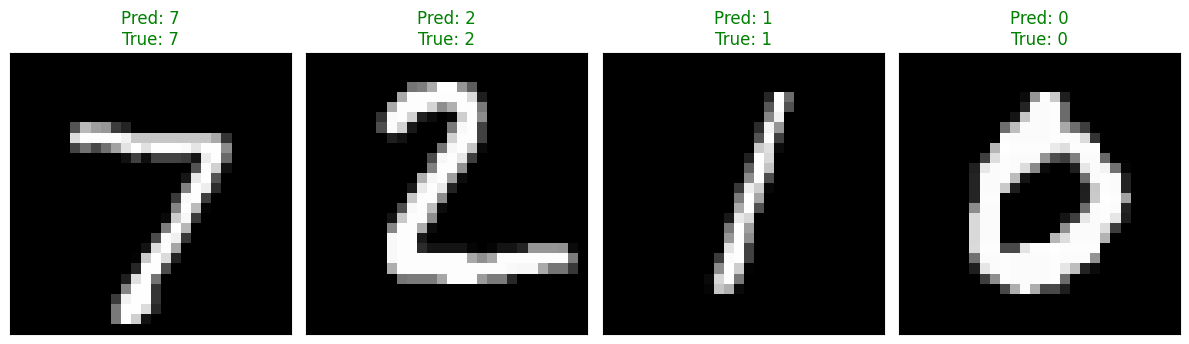

(tensor([7, 2, 1, 0]), tensor([7, 2, 1, 0]))

In [10]:
predict_and_plot(model, test_loader, num_images=4)

In [11]:
torch.save(model, 'mnist_cnn.pth')
print("Model saved to mnist_cnn.pth")

Model saved to mnist_cnn.pth
